# GEOG5995M Final Project
Student ID: 201801028
#### Does deprivation contribute to a higher mental health need in Liverpool?

In [1]:
# Import the required packages

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore');

# Uncomment the below if the packages aren't installed for you 
#!pip install contextily
#!pip install geoplot
#!pip install statsmodels
#!pip install tabulate

In [2]:
# Set the seaborn theme for the rest of the notebook for consistent formatting
custom_params = {"axes.spines.right": False, "axes.spines.top": False} # Make a dict to store custom configeration of parameters
sns.set_theme(style="ticks", rc=custom_params);

## 1) Data exploration and cleaning

In [3]:
# Read in the file with the LSOA codes for Liverpool 
lpl_lsoa = pd.read_csv("liverpool lsoas.csv")
lpl_lsoa.head() # Examine the first five entries to see what the file looks like

,Feature Identifier,Feature Name
0,http://opendatacommunities.org/id/geography/ad...,Liverpool 031A
1,http://opendatacommunities.org/id/geography/ad...,Liverpool 060A
2,http://opendatacommunities.org/id/geography/ad...,Liverpool 037A
3,http://opendatacommunities.org/id/geography/ad...,Liverpool 037B
4,http://opendatacommunities.org/id/geography/ad...,Liverpool 044A


In [4]:
# Extract the LSOA codes pertaining to Liverpool

print(lpl_lsoa.iloc[0,0]) # Show the format of the data in the dataframe
codes = [] # Initialise an empty list to store the modified data

for _,row in lpl_lsoa.iterrows(): # Iterate through each row in the dataset
    val = row[0] # Extract the string
    code = val.split("/") # Split the string by dashes
    codes.append(code) # Append the list of split strings to the list
    
true_codes = [code[-1] for code in codes] # Extract the last element in each list (LSOA), i.e. the code, onto a new list
lsoa_codes = pd.DataFrame(true_codes) # Convert these back into a dataframe so that they can be joined
lsoa_codes.rename(columns={0:"code"},inplace=True) # Provide a column name to use for the join
lsoa_codes.columns

http://opendatacommunities.org/id/geography/administration/lsoa/E01006512


Index(['code'], dtype='object')

#### UK geographies: Explaining LSOAs
Note: LSOA = Lower layer Super Output Area. A way to break the country into small areas (neighbourhoods) for better statistical reporting. <a href="https://geoportal.statistics.gov.uk/documents/ons::a-beginners-guide-to-uk-geography-2021-v1-0-1/explore">[1]</a>
LSOA level data has been used for this project; given that the focus is on a particular city, it is informative to break that down further into neighbourhoods. 

Liverpool LSOA codes from <a href="https://opendatacommunities.org/atlas/resource?uri=http%3A%2F%2Fopendatacommunities.org%2Fid%2Fgeography%2Fadministration%2Fmd%2FE08000012&collection-uri=http%3A%2F%2Fopendatacommunities.org%2Fdef%2Ffoi%2Fcollection%2Flsoas&offset=0&limit=298">[2]</a>

In [5]:
# Read in the shapefile with the coordinates for the polygons of all the LSOAs in the UK 
lsoa_boundaries = gpd.read_file("LSOA_2021_EW_BGC.shp") # Load in the shapefile for LSOAs around Liverpool
# Show the columns in the file
print(lsoa_boundaries.columns)
# Merge the shape file and LSOA codes to ensure the variable is a geodataframe
lsoa_liv_spat = lsoa_boundaries.merge(lsoa_codes,left_on="LSOA21CD",right_on="code",how="inner") # Inner join to avoid null values
lsoa_liv_spat.shape # Check that the new dataframe just contains the 286 Liverpool LSOAs 

Index(['LSOA21CD', 'LSOA21NM', 'GlobalID', 'geometry'], dtype='object')


(286, 5)

In [6]:
# Check that the merge has preserved the data type as geodataframe
type(lsoa_liv_spat)

geopandas.geodataframe.GeoDataFrame

In [7]:
# Inspect the geodataframe
print(lsoa_liv_spat.dtypes)
lsoa_liv_spat.head()

LSOA21CD      object
LSOA21NM      object
GlobalID      object
geometry    geometry
code          object
dtype: object


,LSOA21CD,LSOA21NM,GlobalID,geometry,code
0,E01006512,Liverpool 031A,9752a2dc-d193-45d5-931d-4c89e6252869,"POLYGON ((335888.000 390042.000, 336216.839 39...",E01006512
1,E01006514,Liverpool 037A,c038c5fa-513a-4d2e-a391-9f87f797ff9b,"POLYGON ((335650.536 389928.121, 335677.916 38...",E01006514
2,E01006518,Liverpool 044A,370b8dc1-7511-486b-8d14-a356e7497dd2,"POLYGON ((335528.316 389067.946, 335612.896 38...",E01006518
3,E01006519,Liverpool 056A,eef78eef-3f52-422d-ba31-f8dd9150add4,"POLYGON ((338426.000 386086.000, 338466.896 38...",E01006519
4,E01006520,Liverpool 043A,e5331942-8e5d-4d23-8e94-f98e5fd0a131,"POLYGON ((337061.170 388034.351, 337081.561 38...",E01006520


In [8]:
# Check the coordinate system for the geodataframe
lsoa_liv_spat.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

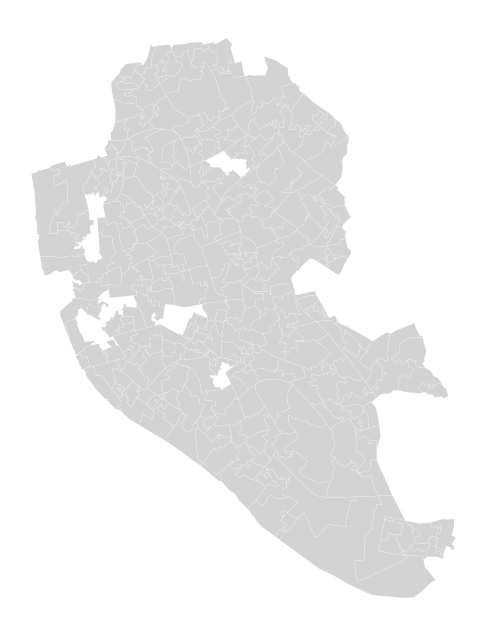

In [9]:
# Plot the geodataframe as a map to check that the joins have worked as expected
f, ax = plt.subplots(1, figsize=(16, 8))

lsoa_liv_spat.plot(ax=ax,color='lightgrey',linewidth=0.1) # Plot the lsoa boundaries
ax.set_axis_off() # Remove the axes as it isn't relevant for mapping
plt.show();

#### Variables in this project:
This project utilises the Index of Multiple Deprivation (IMD) and Small Area Mental Health Index (SAMHI). The IMD is a measure of relative deprivation for neighbourhoods in England, and part of a host of Indices of Deprivation. It ranks every LSOA from 1 (most deprived) to 32,844 (least deprived). It is comprised of the following domains:
* Income Deprivation
* Employment Deprivation
* Education, Skills and Training Deprivation
* Health Deprivation and Disability
* Crime
* Barriers to Housing and Services
* Living Environment Deprivation
 
(Noble et al., 2019, p3) <a href="https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019">[3]</a>

The SAMHI (Barr & Daras, 2021) is a "composite measure of population mental health for each [...] LSOA in England", standardised to  have a mean of 0 and standard deviation of 1, made up of data on:
* National Health Service (NHS) mental-health related hospital attendances
* Prescription level information on antidepressants
* NHS frameworks on depression
* Department for Work and Pensions (DWP) data on Incapacity benefit and Employment support allowance for mental illness
<a href="https://pldr.org/dataset/2noyv/small-area-mental-health-index-samhi">[4]</a>


<!-- <span style="color:red"> Need to explain what they are briefly  </span>

In [10]:
# Read deprivation and mental health data from csv files into dataframes
dep = pd.read_csv("File_5_-_IoD2019_Scores.csv")
mh = pd.read_csv("samhi_21_01_v4.00_2011_2019_LSOA.csv")
print(f"Deprivation {dep.columns} \n Mental health {mh.columns}") # Examine the columns in each dataframe

Deprivation Index(['LSOA code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)',
       'Index of Multiple Deprivation (IMD) Score', 'Income Score (rate)',
       'Employment Score (rate)', 'Education, Skills and Training Score',
       'Health Deprivation and Disability Score', 'Crime Score',
       'Barriers to Housing and Services Score', 'Living Environment Score',
       'Income Deprivation Affecting Children Index (IDACI) Score (rate)',
       'Income Deprivation Affecting Older People (IDAOPI) Score (rate)',
       'Children and Young People Sub-domain Score',
       'Adult Skills Sub-domain Score',
       'Geographical Barriers Sub-domain Score',
       'Wider Barriers Sub-domain Score', 'Indoors Sub-domain Score',
       'Outdoors Sub-domain Score'],
      dtype='object') 
 Mental health Index(['lsoa11', 'samhi_index.2011', 'samhi_dec.2011', 'samhi_index.2012',
       'samhi_dec.2012', 'samhi_index.2013', 

In [11]:
# Merge the geodataframe with the two dataframes above
lsoa_liv = pd.merge(lsoa_liv_spat,pd.merge(dep,mh,left_on="LSOA code (2011)",right_on="lsoa11",how="inner"),left_on="LSOA21CD",right_on="lsoa11",how="inner") # Inner join to avoid nulls
lsoa_liv.head() # Examine the new geodataframe

,LSOA21CD,LSOA21NM,GlobalID,geometry,code,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,...,samhi_index.2015,samhi_dec.2015,samhi_index.2016,samhi_dec.2016,samhi_index.2017,samhi_dec.2017,samhi_index.2018,samhi_dec.2018,samhi_index.2019,samhi_dec.2019
0,E01006512,Liverpool 031A,9752a2dc-d193-45d5-931d-4c89e6252869,"POLYGON ((335888.000 390042.000, 336216.839 39...",E01006512,E01006512,Liverpool 031A,E08000012,Liverpool,19.654,...,-0.728737,3,-0.584247,3,-0.509595,2,-0.471959,2,-0.275110,2
1,E01006514,Liverpool 037A,c038c5fa-513a-4d2e-a391-9f87f797ff9b,"POLYGON ((335650.536 389928.121, 335677.916 38...",E01006514,E01006514,Liverpool 037A,E08000012,Liverpool,43.775,...,2.176122,10,1.560459,10,1.696295,10,1.703827,9,2.057036,9
2,E01006518,Liverpool 044A,370b8dc1-7511-486b-8d14-a356e7497dd2,"POLYGON ((335528.316 389067.946, 335612.896 38...",E01006518,E01006518,Liverpool 044A,E08000012,Liverpool,68.396,...,2.917227,10,3.000884,10,3.673690,10,4.028374,10,4.348603,10
3,E01006519,Liverpool 056A,eef78eef-3f52-422d-ba31-f8dd9150add4,"POLYGON ((338426.000 386086.000, 338466.896 38...",E01006519,E01006519,Liverpool 056A,E08000012,Liverpool,10.183,...,-0.152053,6,0.046741,6,0.320765,6,0.195848,5,0.391017,5
4,E01006520,Liverpool 043A,e5331942-8e5d-4d23-8e94-f98e5fd0a131,"POLYGON ((337061.170 388034.351, 337081.561 38...",E01006520,E01006520,Liverpool 043A,E08000012,Liverpool,43.117,...,2.642489,10,2.815545,10,2.982021,10,3.554723,10,3.445858,10


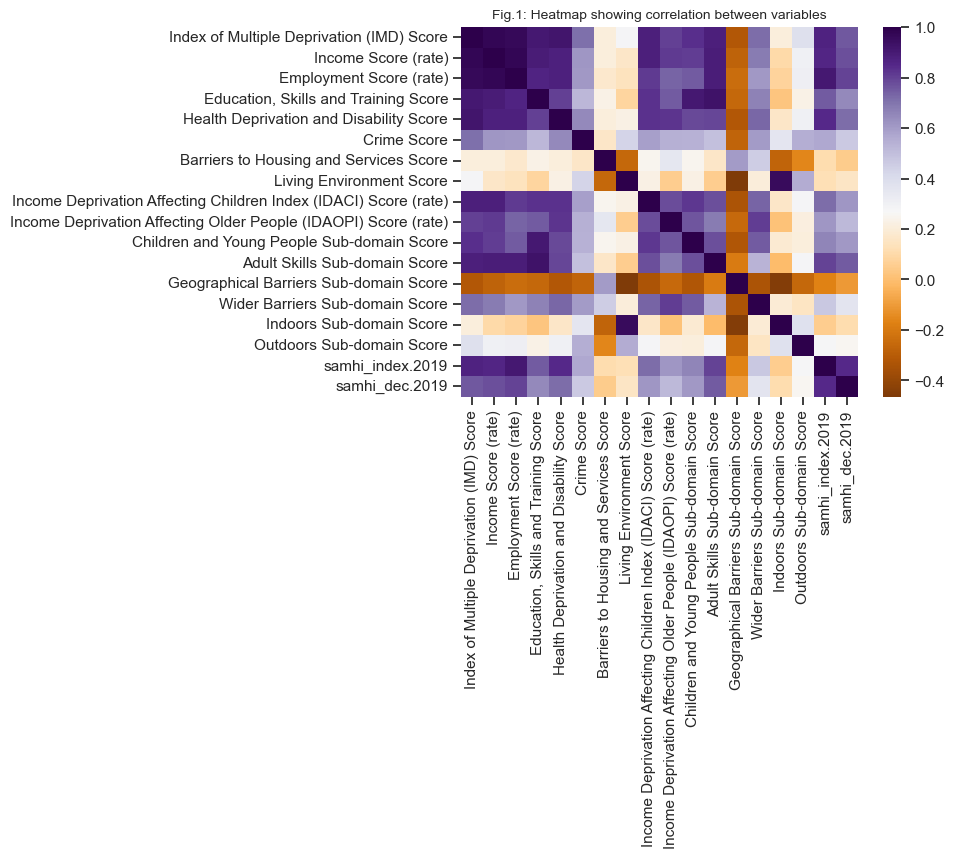

In [12]:
# Find the correlation between the variables in the dataframe

acc_vals= lsoa_liv.select_dtypes(include=np.number) # Only include numeric variables 
# Drop the small area mental health indices from older years 
vals = acc_vals.drop(axis=1,labels=['samhi_index.2011', 'samhi_dec.2011', 'samhi_index.2012',
       'samhi_dec.2012', 'samhi_index.2013', 'samhi_dec.2013',
       'samhi_index.2014', 'samhi_dec.2014', 'samhi_index.2015',
       'samhi_dec.2015', 'samhi_index.2016', 'samhi_dec.2016',
       'samhi_index.2017', 'samhi_dec.2017', 'samhi_index.2018',
       'samhi_dec.2018'],inplace=False)
_corr = sns.heatmap(vals.corr(),cmap="PuOr",annot=False) # Create a heatmap based on the correlation between variables in the dataset
_corr.set_title("Fig.1: Heatmap showing correlation between variables",fontsize="small")
plt.show();

#### Selecting variables

We can see that the SAMHI index ```samhi_index.2019``` and SAMHI deciles ```samhi_dec.2019``` are most strongly correlated with the top 5 scores (```IMD```; ```Income```; ```Employment```; ```Education, Skills, and Training```; ```Health Deprivation and Disability```) and ```Adult Skills```. As aforementioned, most of these scores are combined into the IMD score, therefore it makes sense to focus on this from the deprivation point of view. The maps below demonstrate that using the SAMHI deciles makes interpretation harder; most of the LSOAs in Liverpool are in the most deprived decile (10), which takes away a lot of the granularity and consequent richness and variation of data found in the SAMHI score. Therefore, we will go forward with SAMHI score.

In [13]:
# Find the correlation score between the two chosen variables
print(f"Correlation between SAMHI and IMD: {lsoa_liv['samhi_index.2019'].corr(lsoa_liv['Index of Multiple Deprivation (IMD) Score']).round(2)}");

Correlation between SAMHI and IMD: 0.87


In [15]:
# Get rid of the unnecessary columns that don't pertain to this report
lsoa_liv_clean = lsoa_liv.drop(axis=1,labels=['code','LSOA21NM','LSOA code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)','lsoa11','Income Score (rate)',
       'Employment Score (rate)', 'Education, Skills and Training Score',
       'Health Deprivation and Disability Score', 'Crime Score',
       'Barriers to Housing and Services Score', 'Living Environment Score',
       'Income Deprivation Affecting Children Index (IDACI) Score (rate)',
       'Income Deprivation Affecting Older People (IDAOPI) Score (rate)',
       'Children and Young People Sub-domain Score',
       'Adult Skills Sub-domain Score',
       'Geographical Barriers Sub-domain Score',
       'Wider Barriers Sub-domain Score', 'Indoors Sub-domain Score',
       'Outdoors Sub-domain Score',
       'Local Authority District name (2019)','samhi_index.2011', 'samhi_dec.2011', 'samhi_index.2012',
       'samhi_dec.2012', 'samhi_index.2013', 'samhi_dec.2013',
       'samhi_index.2014', 'samhi_dec.2014', 'samhi_index.2015',
       'samhi_dec.2015', 'samhi_index.2016', 'samhi_dec.2016',
       'samhi_index.2017', 'samhi_dec.2017', 'samhi_index.2018',
       'samhi_dec.2018'],inplace=False)
# Rename the two variable names for ease of reference 
lsoa_liv_clean.rename(columns={'Index of Multiple Deprivation (IMD) Score':'IMD','samhi_index.2019':'SAMHI'},inplace=True)
# Show the structure of the cleaned dataframe
lsoa_liv_clean.head()

,LSOA21CD,GlobalID,geometry,IMD,SAMHI,samhi_dec.2019
0,E01006512,9752a2dc-d193-45d5-931d-4c89e6252869,"POLYGON ((335888.000 390042.000, 336216.839 39...",19.654,-0.275110,2
1,E01006514,c038c5fa-513a-4d2e-a391-9f87f797ff9b,"POLYGON ((335650.536 389928.121, 335677.916 38...",43.775,2.057036,9
2,E01006518,370b8dc1-7511-486b-8d14-a356e7497dd2,"POLYGON ((335528.316 389067.946, 335612.896 38...",68.396,4.348603,10
3,E01006519,eef78eef-3f52-422d-ba31-f8dd9150add4,"POLYGON ((338426.000 386086.000, 338466.896 38...",10.183,0.391017,5
4,E01006520,e5331942-8e5d-4d23-8e94-f98e5fd0a131,"POLYGON ((337061.170 388034.351, 337081.561 38...",43.117,3.445858,10


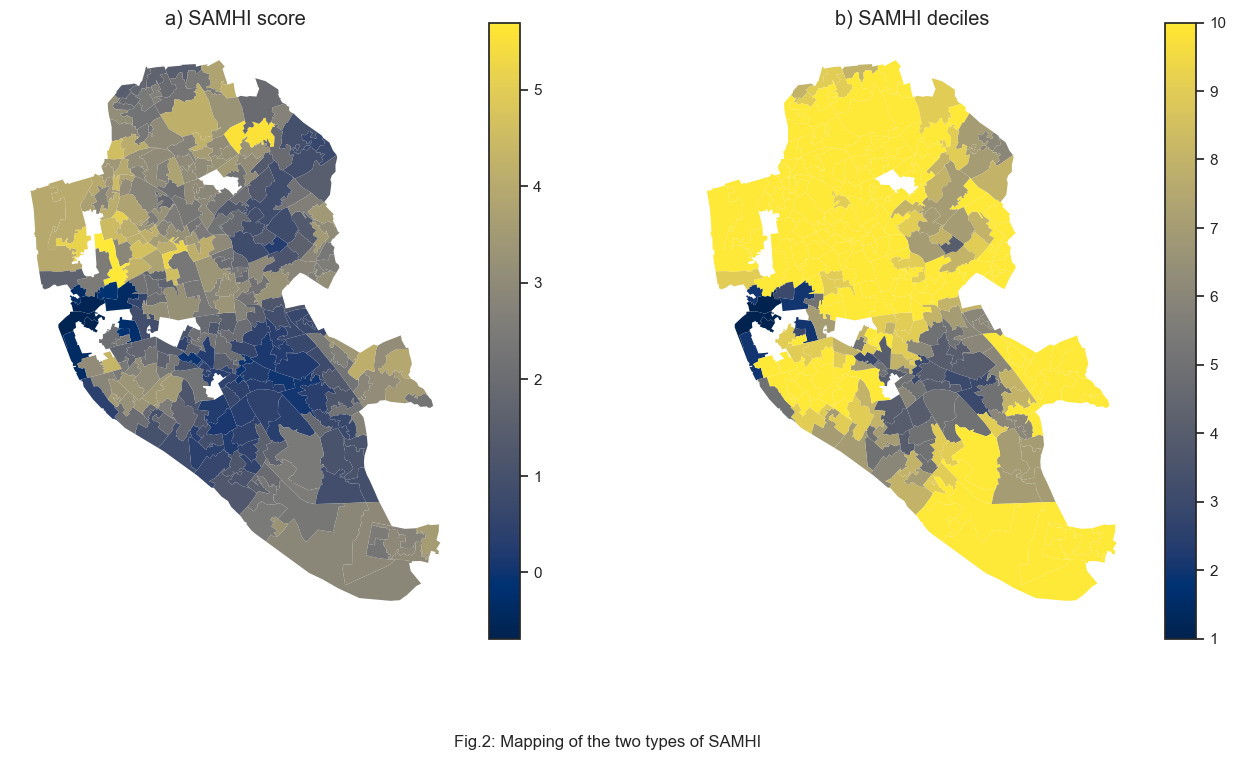

In [16]:
fig,ax = plt.subplots(1,2, figsize=(16,8)) # Create the figure of the specified size

# or should i use SOA_pct SOA_decile --- i've completely changed this and i'm not sure why lol 
lsoa_liv_clean.plot(ax=ax[0],column="SAMHI",legend=True,cmap='cividis',linewidth=0.01) # Plot the choropleth map based on the "rate" column, using the "cividis" colorscheme
#plt.text(x=53,y=32,s="Iran",fontweight="semibold") # Add some text, positioned over the country with the highest rate of mental illness
# Higher value = higher levels of need (SAMHI)
lsoa_liv_clean.plot(ax=ax[1],column='samhi_dec.2019',legend=True,cmap='cividis',linewidth=0.01) # Plot the choropleth map based on the "rate" column, using the "cividis" colorscheme

ax[0].set_axis_off()  # Make axis invisible
ax[1].set_axis_off()

# Set titles for the figure and subfigures
plt.suptitle("Fig.2: Mapping of the two types of SAMHI \n",fontsize="medium",y=-0.01)
ax[0].set_title("a) SAMHI score", fontsize="large", y=+1) # Give the figure a title with a specified text size
ax[1].set_title("b) SAMHI deciles", fontsize="large", y=+1) # Give the figure a title with a specified text size

plt.show();

#### Data visualisation to aid data cleaning



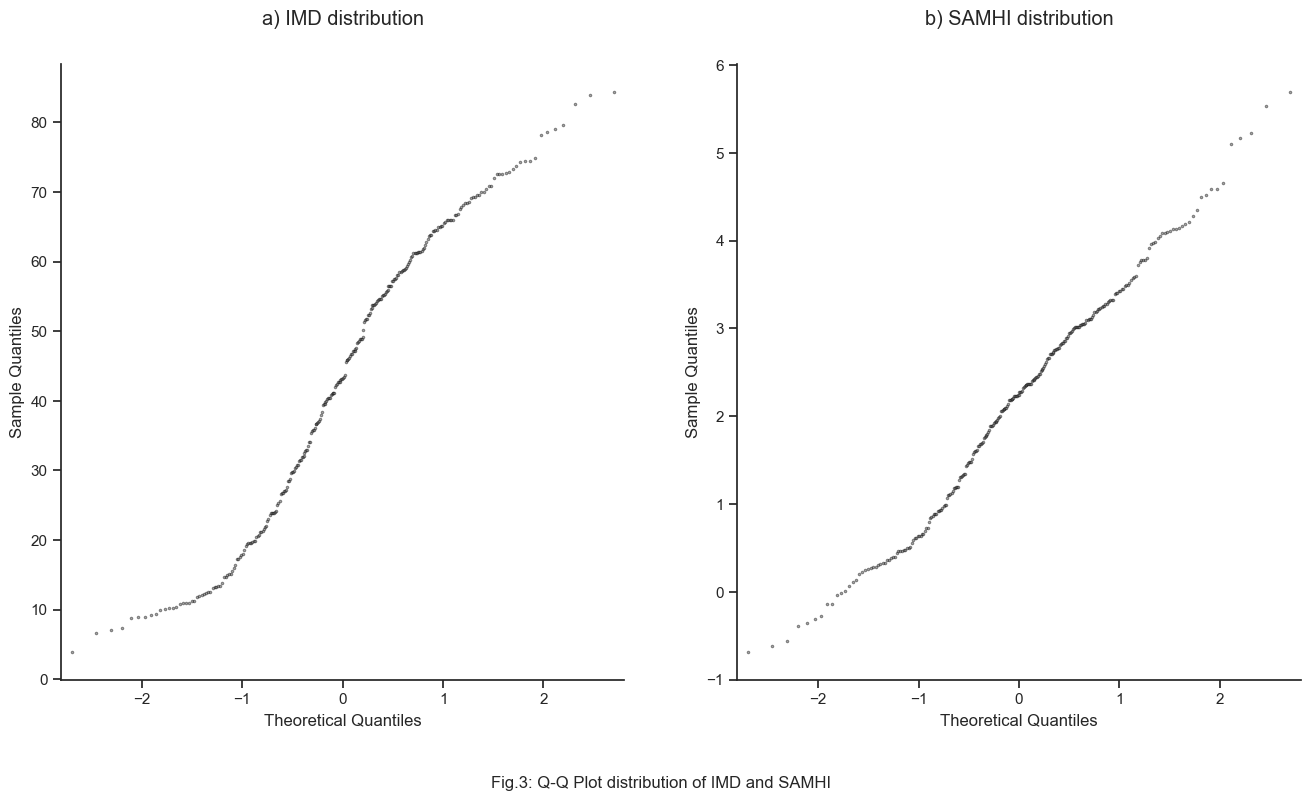

In [17]:
# Plot qqplots to see if variables are normally distributed
f, ax = plt.subplots(1,2, figsize=(16, 8)) # Define figure size

qqplot(ax=ax[0],data=lsoa_liv_clean['IMD'],marker='o',markerfacecolor='white',markeredgecolor='black',markersize=1.5,alpha=0.5)
qqplot(ax=ax[1],data=lsoa_liv_clean['SAMHI'],marker='o',markerfacecolor='white',markeredgecolor='black',markersize=1.5,alpha=0.5)

plt.suptitle("Fig.3: Q-Q Plot distribution of IMD and SAMHI",fontsize="medium",y=-0.01)
ax[0].set_title("a) IMD distribution", fontsize="large", y=+1.05) # Give the figure a title with a specified text size
ax[1].set_title("b) SAMHI distribution", fontsize="large", y=+1.05) # Give the figure a title with a specified text size
plt.show();

In [18]:
# Descriptive statistics for each of the chosen variables
imd_stats = lsoa_liv_clean["IMD"] # Create pandas series to calculate stats  
samhi_stats = lsoa_liv_clean["SAMHI"]

# Calculate measures of central tendency and skew and put in table format 
dstats = [["IMD",imd_stats.mean().round(2),imd_stats.median().round(2),imd_stats.std().round(2),imd_stats.skew().round(2)],["SAMHI",samhi_stats.mean().round(2),samhi_stats.median().round(2),samhi_stats.std().round(2),samhi_stats.skew().round(2)]]
print("Fig.4: Descriptive statistics")
# Use tabulate package to create table object
print(tabulate(dstats,headers=["Variable","Mean","Median","St. Deviation","Skew"],tablefmt="double_grid"))

Fig.4: Descriptive statistics
╔════════════╦════════╦══════════╦═════════════════╦════════╗
║ Variable   ║   Mean ║   Median ║   St. Deviation ║   Skew ║
╠════════════╬════════╬══════════╬═════════════════╬════════╣
║ IMD        ║  42.81 ║    43.21 ║            20.5 ║  -0.09 ║
╠════════════╬════════╬══════════╬═════════════════╬════════╣
║ SAMHI      ║   2.17 ║     2.26 ║             1.3 ║   0.02 ║
╚════════════╩════════╩══════════╩═════════════════╩════════╝


In [19]:
# Check whether there are any null values
lsoa_liv_clean.isnull().sum()

LSOA21CD          0
GlobalID          0
geometry          0
IMD               0
SAMHI             0
samhi_dec.2019    0
dtype: int64

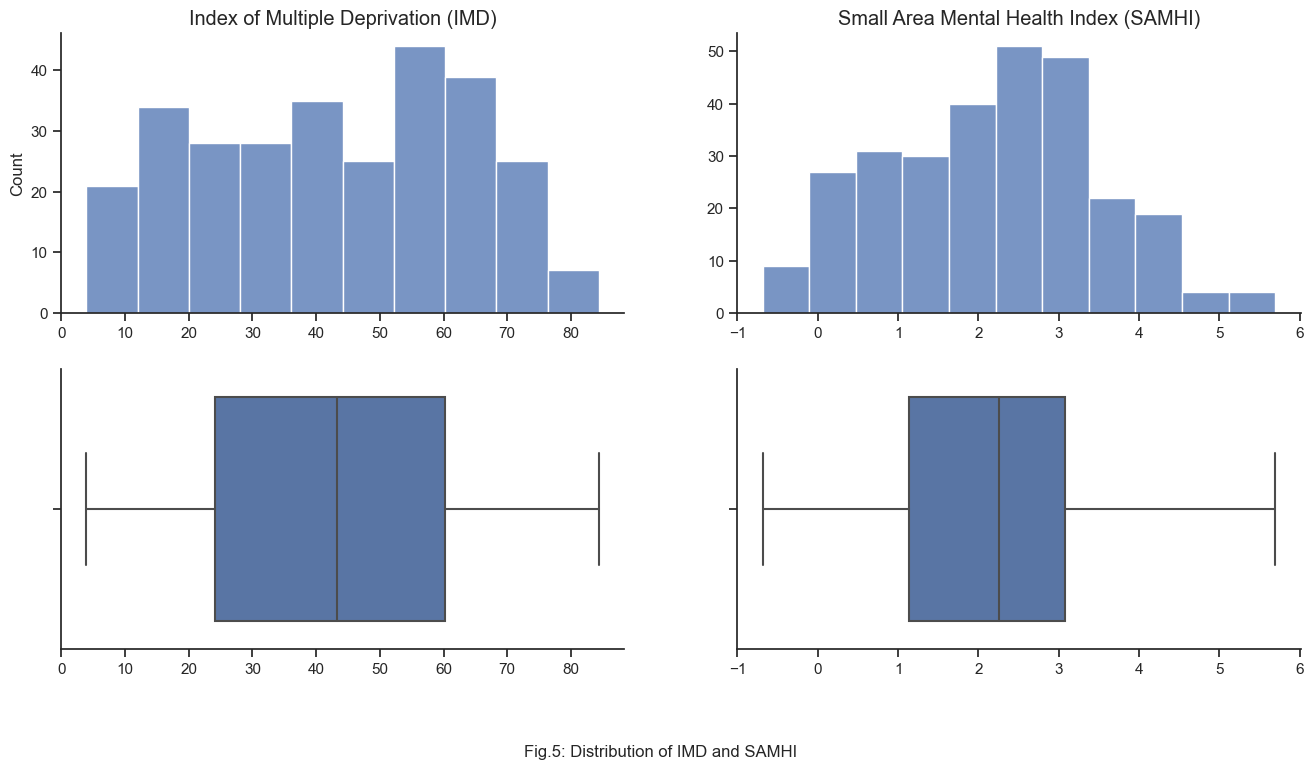

In [20]:
# Check if there are any outliers using some different plots 

# Define figure size including four subplots
f, ax = plt.subplots(2,2, figsize=(16, 8))
# Create histplots for both variables on the top row of faceting
sns.histplot(ax=ax[0,0],data=lsoa_liv_clean,x="IMD")
ax[0,0].set_xlabel("")
ax[0,0].set_title("Index of Multiple Deprivation (IMD)",fontsize="large")
sns.histplot(ax=ax[0,1],data=lsoa_liv_clean,x="SAMHI")
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")
ax[0,1].set_title("Small Area Mental Health Index (SAMHI)",fontsize="large")

# Create boxplots for both variables on the bottom row of faceting
sns.boxplot(ax=ax[1,0],data=lsoa_liv_clean,x="IMD")
ax[1,0].set_xlabel("")
sns.boxplot(ax=ax[1,1],data=lsoa_liv_clean,x='SAMHI')
ax[1,1].set_xlabel("")

plt.suptitle("Fig.5: Distribution of IMD and SAMHI",fontsize="medium",y=-0.01);

#### Interpretation of graphs
The graphs and statistics above show that both variables are fairly normally distributed. Looking at the qqplots, IMD is possibly slightly light-tailed (meaning that there is more data located at either end of the distribution), and SAMHI is more normal (the curve being straighter). Looking at the histograms and box plots (and skew value), SAMHI appears to be ever so slightly skewed, but not enough to seriously affect the data. Therefore, we can go ahead and build a linear regression model.

## 2) Statistical modelling

We are using a linear regression model as both variables are continuous, and it will allow us to use the model for prediction of mental health need based on deprivation data. 

In [21]:
# Predict SAMHI score based on IMD score using OLS regression model

# Define X and y
X = lsoa_liv_clean["IMD"] # Independent (explanatory) variable
y = lsoa_liv_clean["SAMHI"] # Dependent variable 

# Fit the model 
model = sm.OLS(y,X).fit()

predictions = model.predict(X) # use the model to make predictions 

# Print out summary statistics from the model 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  SAMHI   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              4092.
Date:                Thu, 30 Nov 2023   Prob (F-statistic):                   4.37e-171
Time:                        15:15:12   Log-Likelihood:                         -280.59
No. Observations:                 286   AIC:                                      563.2
Df Residuals:                     285   BIC:                                      566.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
IMD            0.0515      0.001     63.967      0.000       0.050       0.053
==============================================================================
Omnibus:                       13.921   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.674
Skew:                          -0.214   Prob(JB):                     9.79e-07
Kurtosis:                       4.462   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation and evaluation of the model:

The R$^{2}$ value, which represents the proportion of the SAMHI explained by the IMD, is very high here (93.5%). This suggests that the model explains nearly all of the variability in mental health need, and indicates a strong relationship between the two variables. The p-value here is 0.000, which indicates that the results are statistically significant and therefore most likely did not occur by chance, and therefore that there is a relationship between the variables. The coefficient of 0.0515 indicates that, for every unit of change in the explanatory variable (IMD), there is an increase in the SAMHI of 0.0515. The confidence intervals indicate that there is a 95% chance that the coefficients are likely to fall within 0.050 and 0.053. In other words, we are 95% confident of this. However, though there is a strong correlation between the two variables (0.87), we must remember that correlation does not necessarily indicate that one is the direct result of another. Instead, there could be other underlying factors linking them. There does not appear to be any direct values that are used in calculating both variables (though employment and health data plays a part in both, to some degree), but nevertheless we must be cautious when it comes to drawing conclusions from this data. 


## 3) Visualisations

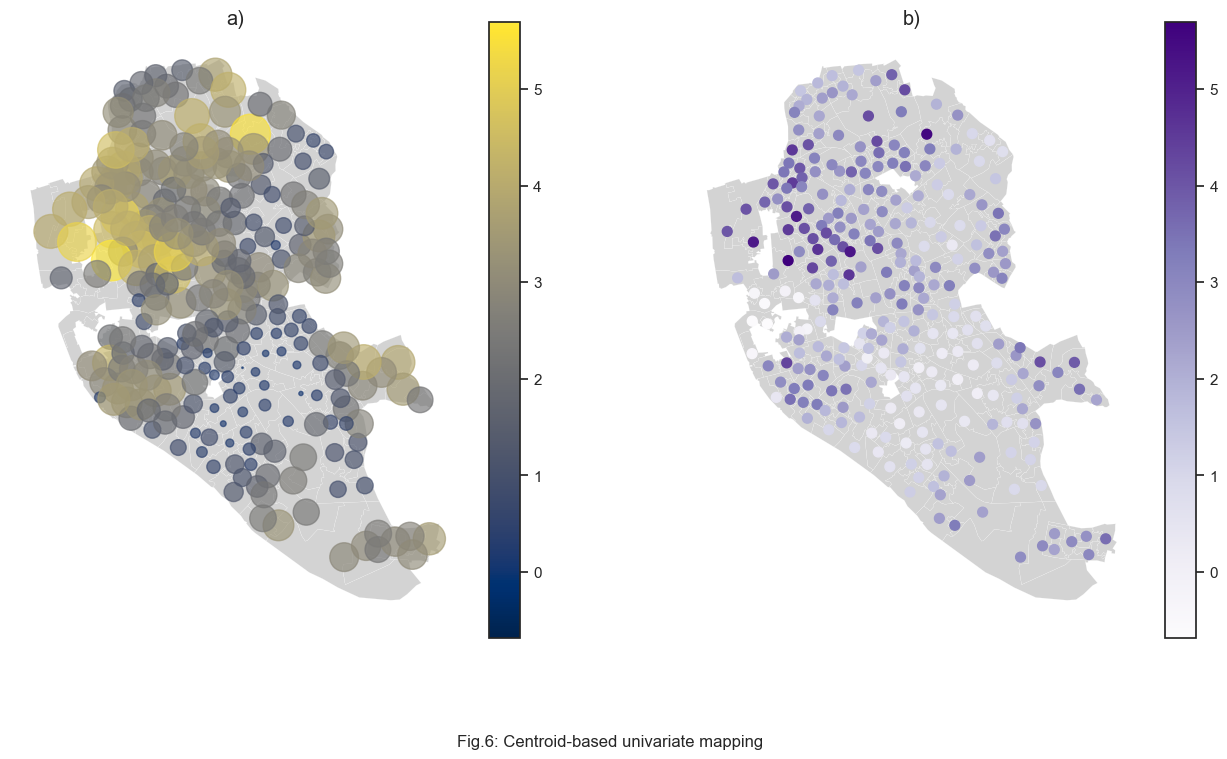

In [22]:
# Calculate centroids 
lpl_centroid = lsoa_liv_clean.copy() # Copy the dataframe
lpl_centroid['geometry'] = lsoa_liv_clean.centroid # Calculate centroids and replace polygon in geometry with points

# Plot one subplot (1 map), with dimensions 16 X 8
f, ax = plt.subplots(1,2, figsize=(16, 8))

# Define the basemap and plot it on the subplot axis
base1 = lsoa_liv_clean.plot(ax=ax[0], color='lightgrey',linewidth=0.1)
base2 = lsoa_liv_clean.plot(ax=ax[1], color='lightgrey',linewidth=0.1)

# Plot the LSOA centroids on the basemap axis with markersize and colourmapping to denote a change in values
lpl_centroid.plot(ax=base1,column='SAMHI',markersize=lsoa_liv_clean['SAMHI']*150, legend=True,alpha=0.65,cmap="cividis")
# Colour the centroids purple with uniform size to see how this changes the visualisation 
lpl_centroid.plot(ax=base2,column='SAMHI',markersize=50, legend=True,alpha=1,cmap="Purples")

plt.suptitle("Fig.6: Centroid-based univariate mapping",fontsize="medium",y=-0.01)
ax[0].set_title("a)",fontsize="large")
ax[1].set_title("b)",fontsize="large")

# Make axis invisible
ax[0].set_axis_off()
ax[1].set_axis_off()

# Show the map
plt.show()

##### Trying centroids:

The map on the left (6a) looks at SAMHI, using both colourmapping and marker size to indicate larger values. The map on the right (6b) uses uniform centroid sizes and a monochrome colourmapping. The right map is slightly more visually easy to interpret, however still not quite right, and doesn't account for both variables. 

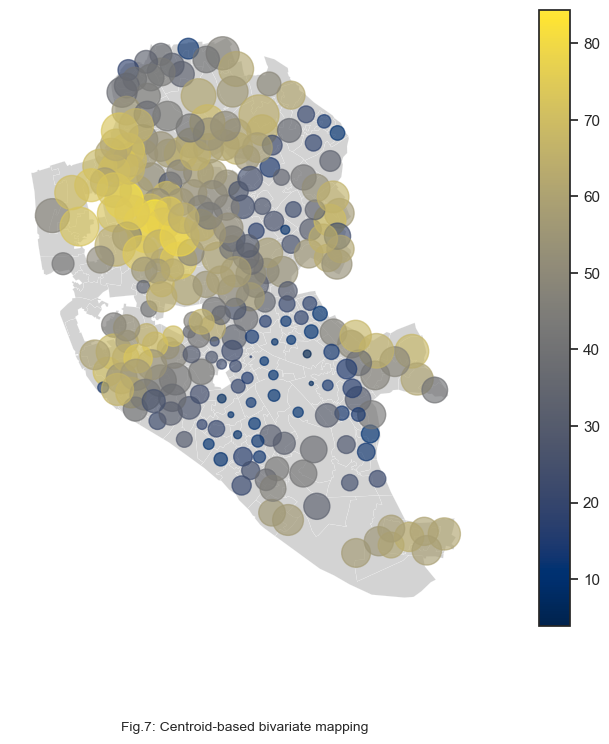

In [23]:
# Define figure size
f, ax = plt.subplots(1, figsize=(16, 8))
# Define the basemap and plot it on the subplot axis
base = lsoa_liv_clean.plot(ax=ax, color='lightgrey',linewidth=0.1)
ax.set_axis_off()
# Plot the centroids with colourmapping to represent IMD and marker size to represent SAMHI
lpl_centroid.plot(ax=base,column='IMD',markersize=lsoa_liv_clean['SAMHI']*150, legend=True,alpha=0.65,cmap="cividis")
plt.suptitle("Fig.7: Centroid-based bivariate mapping",fontsize="small",y=-0.01,x=0.6)

plt.show();

##### Centroids continued: 
This map uses colourmapping to show IMD and markersize to indicated SAMHI, as a spatial way for bivariate visualisation. This is slightly more successful than the previous attempts at using centroids, however is still somewhat difficult to read, especially in terms of trying to pick out both variables at once. 

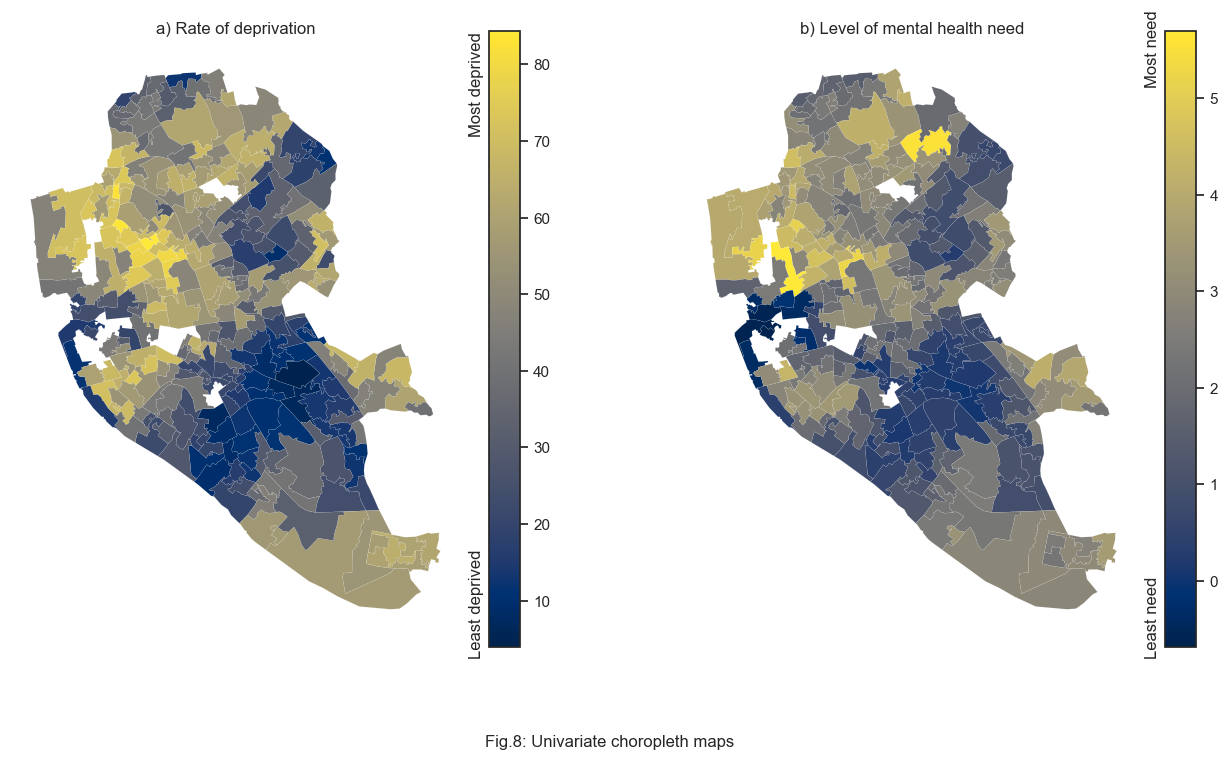

In [24]:
"Final spatial visualisation"

# Define figure size
fig,ax = plt.subplots(1,2, figsize=(16,8)) # Create the figure

lsoa_liv_clean.plot(ax=ax[0],column="IMD",legend=True,cmap='cividis',linewidth=0.05) # Plot the choropleth map based on the IMD column, using the "cividis" colorscheme
lsoa_liv_clean.plot(ax=ax[1],column="SAMHI",legend=True,cmap='cividis',linewidth=0.05) # Plot the choropleth map based on the SAMHI column, using the "cividis" colorscheme


ax[0].set_axis_off()  # Make axis invisible
ax[1].set_axis_off()

plt.suptitle("Fig.8: Univariate choropleth maps",size="medium",y=-0) # Set the label to go underneath the figure
ax[0].set_title("a) Rate of deprivation", fontsize="medium", y=+1) # Give the figure a title with a specified text size
ax[1].set_title("b) Level of mental health need", fontsize="medium", y=+1) # Give the figure a title with a specified text size

# Adjust the legend
ax[0].text(x=346500,y=380000,s="Least deprived",size='medium',rotation=90)
ax[0].text(x=346500,y=396000,s='Most deprived',size='medium',rotation=90)

ax[1].text(x=346500,y=380000,s="Least need",size='medium',rotation=90)
ax[1].text(x=346500,y=397500,s='Most need',size='medium',rotation=90)

plt.show();

### Spatial visualisation

After having initially tried to use centroids, it soon become clear that the data wasn't very clear (as discussed above). After some trial and error, faceted choropleth maps provided the best option for mapping the two variables, leading to the final visualisation in Figure 8. Choropleth maps are standard in academic works, which is the intended audience for this project. Throughout the document, figure labels have been placed below any graphs, maps or other visualisations (apart from fig. 1 where this would have been visually confusing due to the writing on the heatmap, though this is slightly irrelevant as it isn't one of the final visualisations). 

The coordinates/axes have been removed as they aren't relevant to the output of the visualisation; to demonstrate the link between two variables in seeing visually how they vary by LSOA (and ultimately that they are both high in the same areas). The maps have been faceted to allow for easy visual inspection; it is very easy to roughly compare the same LSOA across both maps. The lines separating the LSOAs are white on both maps so that it is visible against the colourmap, and of a thickness that is visible but doesn't overpower the visual effect. The titles and labels on the figures themselves are of a size that makes sense relative to the figure. The titles for each subplot are above the maps; whilst it might be more visually appealing for them to be under the maps, where there is more white spacee, the academic convention is to have them above the figures. Finally, the colourmap was chosen as it is both colourblind-friendly (checked using Colorbrewer <a href="https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=3">[??]</a>) and visually clear. 

Overall, this visualisation drives a simple yet clear message in an effective and compelling manner: areas with high rates of deprivation tend to also have a high level of mental health need, based on the Indices of Multiple Deprivation and Small Area Mental Health Indices for the LSOAs in Liverpool.

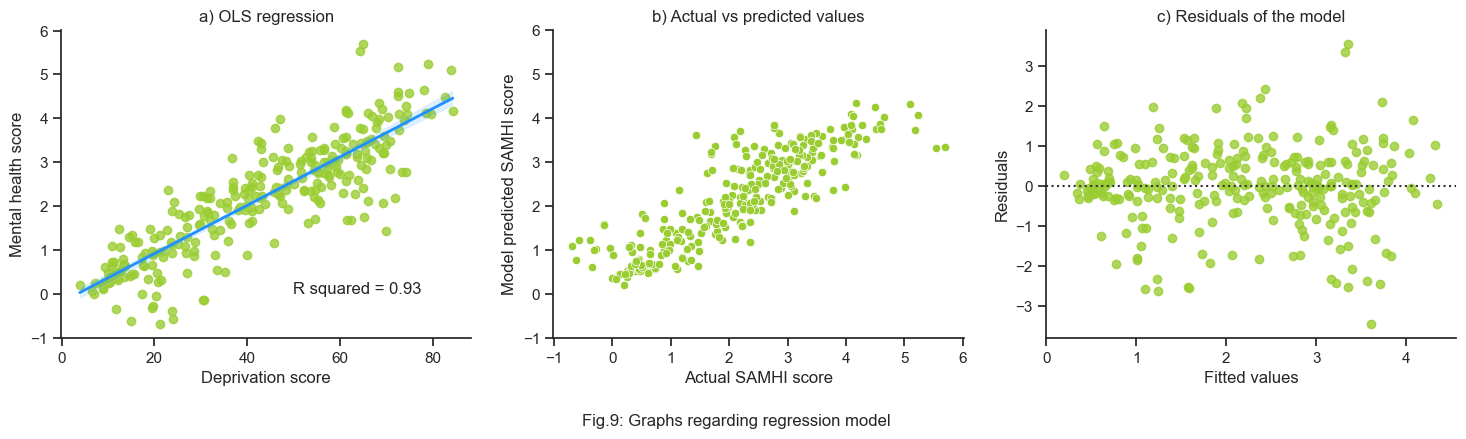

In [34]:
"Final non-spatial visualisation" 

# Define figure size
fig, ax = plt.subplots(1,3,figsize=(18,4))

# Plot regression plot with IMD as the independent variable and SAMHI as the dependent as the first subplot
sns.regplot(ax=ax[0],data=lsoa_liv_clean, x='IMD', y='SAMHI',color='yellowgreen',line_kws={"color":"dodgerblue", "lw":2,"alpha":1});
# Set the labels for the regression 
ax[0].set_xlabel('Deprivation score')
ax[0].set_ylabel('Mental health score') 
ax[0].set_title('a) OLS regression')

# Add r squared value of the model to the plot
r2 = round(model.rsquared,2) # Find the value and round to 2dp, save in a variable
ax[0].text(50, 0, "R squared = " +str(r2), fontsize=12) # Add the r squared as a string to the plot

# Plot a scatterplot with the true SAMHI score against the model predicted score
sns.scatterplot(ax=ax[1],x=lsoa_liv_clean["SAMHI"],y=model.fittedvalues,color='yellowgreen') # Compare true values and those predicted by the model
# Set labels and title
ax[1].set_title("b) Actual vs predicted values")
ax[1].set_xlabel("Actual SAMHI score")
ax[1].set_ylabel("Model predicted SAMHI score")
ax[1].set_ylim(-1, 6) # Change the y-axis to the same start and end values as the x-axis

# Plot a residual graph 
sns.residplot(ax=ax[2],x=model.fittedvalues, y=model.resid_pearson, color='yellowgreen')
# Set the labels and title
ax[2].set_xlabel("Fitted values")
ax[2].set_ylabel("Residuals")
ax[2].set_title("c) Residuals of the model")

plt.suptitle("Fig.9: Graphs regarding regression model",size="medium",y=-0.08) # Set the label to go underneath the figure
plt.show();

### Non-spatial visualisation

The final non-spatial visualisation (figure 9 above) is intended for an academic audience. As such, the background is clear and the top and right spines have been removed as per academic standard. There are labels for the x- and y- axes as they represent different things in each subplot, which also means that the scales are slightly different in each plot. The coordinates are based on a Cartesian system, which is appropriate given the 2d nature of the graphs. The subplots have been faceted to allow for easy visual inspection and clear representation of the linear regression model used for analysis. The figure label is below the graph, as per academic standard. The colour palette follows <a href="https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=3 ">this</a> colourblind-friendly palette. 

In 9a, the independent variable (IMD score) is on the x-axis and the dependent variable (SAMHI score) on the y-axis, as is standard practice. This graph illustrates a strong correlation between the two variables and allows for a fairly accurate regression line to be fitted. The r-squared value is also included on the plot to give some additional context to the graph. 

The second subplot, 9b, illustrates the correlation between the true SAMHI scores and those predicted by the model based on the regression. The scales are therefore the same as both axes pertain to the same variable; note that the default had the x-axis in the range of [-1,6] and the y-axis in [0,5], so the y-axis was changed to mirror the x-axis and avoid any confusion and possiblity for error in interpretation. Inspecting the graph shows that the model on average predicts the SAMHI score slightly higher than the actual score. That said, there isn't that much error in the model, as shown in 9c. The points are evenly dispersed around 0, which shows that the linear regression model is an appropriate statistical technique for these two variables.  

## 4) Concluding remarks

As a local authority, Liverpool has one of the highest proportions of most deprived (defined as lacking of a resource) neighbourhoods in England <a href="https://assets.publishing.service.gov.uk/media/5d8b387740f0b609909b5908/IoD2019_Technical_Report.pdf">[??] </a>. The majority of LSOAs in Liverpool are also in the highest decile of SAMHI; that is, having the most mental health need (see fig.2b). Figure 8 (the spatial visualisation) shows that the same or nearby areas have high rates of deprivation and mental health need. The regression (see fig.9; the non-spatial visualisation) shows that there is a strong correlation between deprivation and mental health need. This insight can be used to prompt further work exploring why there is such a strong correlation, what the underlying factors are, and how these can be addressed. 

## References
<p><a href="https://geoportal.statistics.gov.uk/documents/ons::a-beginners-guide-to-uk-geography-2021-v1-0-1/explore">[1]</a> Explanation of LSOAs </p>
<p><a href="https://statistics.ukdataservice.ac.uk/dataset/2011-census-geography-boundaries-lower-layer-super-output-areas-and-data-zones">[2]</a> Liverpool LSOA boundaries</p>
<p><a href="https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019">[3]</a> Index of Multiple Deprivation (IMD) (file 5) Noble, S., McLennan, D., Noble, M., Plunkett, E., Gutacker, N., Silk, M., & Wright, G. (2019). The English indices of deprivation 2019. CLG Ministry of Housing, Editor. London.</p>
<p><a href="https://pldr.org/dataset/2noyv/small-area-mental-health-index-samhi">[4]</a> Small Area Mental Health Index (SAMHI) Daras K, Barr B (2021), Small Area Mental Health Index (SAMHI) [Open Dataset], Place-based Logitudinal Data Resource, DOI: 10.17638/datacat.liverpool.ac.uk/1188</p>
<p><a href="https://colorbrewer2.org/">[5]</a> Colorbrewer (for checking colorblind-friendly pallettes)</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5995">[6]</a> GEOG5995M course materials</p>
